# Breast Cancer Wisconsin

In [14]:
# To avoid having to rerun everything.
retrain_model = False
rerun_grid = False
rerun_training_data = False

In [2]:
%matplotlib inline
import math
import random
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import ddks
from sklearn import metrics
from sklearn.decomposition import PCA

import torchvision.transforms as T

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import time
import random
random.seed(1)

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.model_selection import train_test_split

writer = SummaryWriter()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


## 1. Data

In [4]:
breast_cancer_data = pd.read_csv("../data/bcw/breast_cancer_data.csv").drop(columns=["id", "Unnamed: 32"])

In [5]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0, 1))

X = breast_cancer_data.iloc[:, 1:].to_numpy()
y = breast_cancer_data.iloc[:, 0].replace({"M": 0, "B": 1}).to_numpy()

minmaxscaler.fit(X)
X = minmaxscaler.transform(X)


X, y = torch.from_numpy(X).float(), torch.from_numpy(y).long()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10, stratify=y)
X_test.shape, y_train.shape


(torch.Size([114, 30]), torch.Size([455]))

In [6]:
X_train = X_train[:450, :]
y_train = y_train[:450]

X_test = X_test[:110, :]
y_test = X_test[:110]

In [7]:
BATCH_SIZE = 10
TEST_BATCH_SIZE = 5


TRAIN_SIZE = len(X_train)
TEST_SIZE = len(X_test)


X_train = torch.split(X_train, BATCH_SIZE)
X_test = torch.split(X_test, TEST_BATCH_SIZE)
y_train = torch.split(y_train, BATCH_SIZE)
y_test = torch.split(y_test, TEST_BATCH_SIZE)


NUM_BATCHES = len(X_train)
NUM_TEST_BATCHES = len(X_test)

CLASSES = 2
TRAIN_EPOCHS = 10 # Endre
SAMPLES = int(len(X)*0.8)
TEST_SAMPLES = int(len(X)*0.2)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

## The Model

In [8]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

# Reparameterized Gaussian
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()
    
# Use a scaled mixture of two Gaussians for the prior distribution on the weights
# These prior parameters are fixed and will not change during training, we therefore
# dont need to use reparameterized Gaussian here:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    
# Single bayesian network layer:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)
    
# Bayesian Neural Network consisting of two 2 fully connected layers:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Flere nodes?
        self.l1 = BayesianLinear(30, 100)
        self.l2 = BayesianLinear(100, 100)
        self.l3 = BayesianLinear(100, 2)
    
    def forward(self, x, sample=False, return_pre=False):
        x = x.view(-1, 30)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x_pre = self.l3(x, sample)
        x = F.softmax(x_pre, dim=1)
        # Velger om man vil returnere pre activation neuron value
        if return_pre:
            return x, x_pre
        else:
            return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES)
        log_priors = torch.zeros(samples)
        log_variational_posteriors = torch.zeros(samples)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss


In [16]:
# Training:
if retrain_model:
    cancer_net = BayesianNetwork()
    def train(net, optimizer, epoch):
        net.train()
        for batch_idx, data, target in zip(range(len(X_train)), X_train, y_train):
            net.zero_grad()
            #print(data)
            loss = cancer_net.sample_elbo(X_train[0], y_train[0])
            loss.backward()
            optimizer.step()

    optimizer = optim.Adam(cancer_net.parameters())
    print("Start")
    for epoch in range(TRAIN_EPOCHS):
        train(cancer_net, optimizer, epoch)
        print(f"Epoch {epoch+1}/{TRAIN_EPOCHS}")
    print("Ferdig")
    
if not retrain_model:
    fileObj = open('../models/bcw/net_bcw.obj', 'rb')
    cancer_net = pickle.load(fileObj)
    fileObj.close()
    print(cancer_net)

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (l3): BayesianLinear()
)


## 3. Testing

In [17]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0, 1))

X = breast_cancer_data.iloc[:, 1:].to_numpy()
y = breast_cancer_data.iloc[:, 0].replace({"M": 0, "B": 1}).to_numpy()

minmaxscaler.fit(X)
X = minmaxscaler.transform(X)


X, y = torch.from_numpy(X).float(), torch.from_numpy(y).long()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10, stratify=y)
X_test.shape, y_train.shape


X_train = X_train[:450, :]
y_train = y_train[:450]

X_test = X_test[:110, :]
y_test = y_test[:110]

In [24]:
class testing_framework:
    def __init__(self,
                 X_train_results,
                 two_sided=False):
        
        self.two_sided = two_sided
        
        # Training data y_true, y_pred, entropy and pre-activations
        [self.X_train_y_pred,
         self.X_train_entropy_1,
         self.X_train_preacts] = [X_train_results[:, 0],
                                  X_train_results[:, 1],
                                  X_train_results[:, 2:]] 
        
   
        
        self.results = pd.DataFrame()
        self.FDR_results = pd.DataFrame()
        self.POWER_results = pd.DataFrame()
        self.ACC_results = pd.DataFrame()
        self.times = pd.DataFrame()
        self.ood_or_ib = pd.DataFrame()
        
    def new_test(self, 
                 pre_act_data,
                 entropy_data,
                 threshold_pre_act,
                 threshold_entropy,
                 entropy=True,
                 pre_act=True):
        # For storing results
        results = np.zeros(len(pre_act_data))
        # Number of pre-activation samples from training data
        len_X_train = len(self.X_train_preacts[:, 0])
        # Turn pre_activations from training data into absolute values
        train_samples_abs = self.X_train_preacts[:, 0]
        
        # For each test pre-activation test sample
        for idx, (pre_act_i, entropy_i) in enumerate(zip(pre_act_data, entropy_data)):
            
            # Absolute value of pre-activation test sample
            pre_act_i_abs = np.max(pre_act_i)
            #print(pre_act_i_abs)
            
            # Number of pre-activation values from training data the are over pre_act_i_abs 
            n_over = len(train_samples_abs[train_samples_abs > pre_act_i_abs])
            n_under = len(train_samples_abs[train_samples_abs < pre_act_i_abs])
            
            
            # Two-sided p-value
            self.two_sided_pvalue = 2*min(n_over/len_X_train, n_under/len_X_train)
            
            # Divide by number of pre-act values from training data
            test_statistic_1 = n_over/len_X_train
            test_statistic_2 = n_under/len_X_train
            
            
            if self.two_sided:
                test_statistic_1, test_statistic_2 = self.two_sided_pvalue, self.two_sided_pvalue
            
            # Divide by number of pre-act values from training data
            #test_statistic_1 = n_over/len_X_train
            #test_statistic_2 = n_under/len_X_train
            
            
            
            # If test_statistic under given threshold, mark as outlier
            if entropy == True and pre_act == True:
                if  (test_statistic_1 < threshold_pre_act) or (test_statistic_2 < threshold_pre_act) or (entropy_i > threshold_entropy):
                    results[idx] = 1
            elif entropy == False and pre_act == True:
                if (test_statistic_1 < threshold_pre_act) or (test_statistic_2 < threshold_pre_act):
                    results[idx] = 1
            elif entropy == True and pre_act == False:
                if (entropy_i > threshold_entropy):
                    results[idx] = 1
            else:
                print("No method.")
                
        if entropy == True and pre_act == True:
            self.results[f"PRE-ACT+ENT"] = results
        elif entropy == False and pre_act == True:
            self.results[f"PRE-ACT"] = results
        elif entropy == True and pre_act == False:
            self.results[f"ENT"] = results
                
    
    @staticmethod
    def POWER_FDR(y_true_outlier,   # 220 sampels. If outlier (1) or not (0) (factual)
                  y_hat_outlier,    # 220 sampels. Outlier Prediction (if the model thinks it is an outlier (1) or not (0))
                  y_true_class,     # 220 sampels. True class (The actual classes, in this case 0 (not cancer) or 1 (cancer))
                  y_hat_class):     # 220 sampels. Predicted class (What the model prodicted, 0 (not cancer) or 1 (cancer))
        
        cm = metrics.confusion_matrix(y_true_outlier, 
                                      y_hat_outlier)
        
        
        FP = cm[0, 1]
        TP = cm[0, 0]
        FN = cm[1, 0]
        TN = cm[1, 1]
                
        FDR = FP/(FP+TP)
        POWER = 1 - FN/(TP+FN)
        
        
        preds_true = [] # For storing true class when not predicted as an outlier
        preds = []      # For storing the class prediction when not predicted as an outlier
        for y_i_true, y_i_hatt, outlier in zip(y_true_class, y_hat_class, y_hat_outlier):
            if outlier == 0: # If not outlier
                preds_true.append(y_i_true)
                preds.append(y_i_hatt)
                # len(preds_true) == len(preds) in all cases 


        ACC = accuracy_score(preds_true, preds)


        return [POWER], [FDR], [ACC]
    
    
    
    def test_FDR_and_POWER(self, y_true_out, 
                           results_table, 
                           y_pred, 
                           y_hatt_pred):
        for col in results_table.columns:
            [self.POWER_results[col], 
            self.FDR_results[col],
            self.ACC_results[col]] = self.POWER_FDR(y_true_out, 
                                                    results_table[col],
                                                    y_pred, 
                                                    y_hatt_pred)

In [25]:
class predict_from_model_breast:
    def __init__(self, model):
        self.model = model
        
    @staticmethod  
    def entropy_func_1(y_hatt):
        return scipy.stats.entropy(y_hatt) 
    
    def predict(self, data_point, type_pre_act=1, n=10):
        """
        Plot for å se om resultatene gir mening.
        """
        tensor_data = torch.FloatTensor(data_point)
        #preds = np.zeros(n)
        _, pre_act = self.model(tensor_data, sample=True, return_pre=True)
        pre_acts_1 = np.zeros((n, len(pre_act[0])))
        pre_acts_2 = np.zeros((n, len(pre_act[0])))
        preds = np.zeros(n)
        
        soft_output = np.zeros((n, len(pre_act[0])))
        
        for i in range(n):
            # Sampler softmax activations og pre-activations
            soft_a, pre_act = self.model(tensor_data, sample=True, return_pre=True)
            # Predikerer klassen med høyest sannsynlighet
            preds[i] = torch.argmax(soft_a[0])
            
            # Lagrer softmax aktiveringene
            soft_output[i, :] = soft_a[0].detach().numpy()
            # Lagrer pre-aktiveringene
            pre_acts_2[i, :] = pre_act[0].detach().numpy()
            
            # Lagrer pre-aktiveringer i sortert rekkefølge
            for j in range(len(pre_act[0])):
                pre_acts_1[i, j] = np.sum(np.sort(pre_act[0].detach().numpy())[-(j+1):]) 
        
        # Den endelige predikerte klassen er den som predikert flest ganger
        predicted_class = np.bincount(preds.astype(int)).argmax()
        
        # Predictive entropy fra gjennomsnittet av alle softmax outputene
        entropy_1 = self.entropy_func_1(soft_output.mean(0))
        
        # Tar gjennomnsittet av pre-aktiveringene (uavhengig av klasse)
        pre_acts_2_mean = pre_acts_2.mean(0)
        # Lagrer array som skal sortere pre-aktiveringene
        pre_acts_2_sorted = np.zeros(len(pre_act[0]))
        # Lagrer Max1, max2, etc...
        for j in range(len(pre_act[0])):
                pre_acts_2_sorted[j] = np.sum(np.sort(pre_act[0].detach().numpy())[-(j+1):]) 
        
        # Velger hvilken metode for lagring av pre-aktiveringer som skal lagres.
        if type_pre_act == 1:
            return [predicted_class, entropy_1, *np.mean(pre_acts_1, axis=0)] 
        else:
            return [predicted_class, entropy_1, *pre_acts_2_sorted] 
    
    
                    
    

In [26]:
pr_sim = predict_from_model_breast(cancer_net)
steps = np.linspace(-0.5, 1.5, num=101)
n_steps = len(steps)
coords_200 = np.zeros(shape=(n_steps*n_steps, 5)) # Endre coords_25
t=0
results_train = np.zeros((len(X_train[:, 0]), 4))

for samp in X_train:
    results_train[t, :] = pr_sim.predict(samp, type_pre_act=2)
    t += 1
    if t % 100 == 0:
        print(f"Progresjon: {t}/{n_steps*n_steps}")
        
pd.DataFrame(results_train) 




pr_sim = predict_from_model_breast(cancer_net)
steps = np.linspace(-0.5, 1.5, num=101)
n_steps = len(steps)
coords_200 = np.zeros(shape=(n_steps*n_steps, 5)) # Endre coords_25
t=0
results_test = np.zeros((len(X_test[:, 0]), 4))

for samp in X_test:
    #print(pr_sim.predict([x, y], type_pre_act=2))
    results_test[t, :] = pr_sim.predict(samp, type_pre_act=2)
    t += 1
    if t % 100 == 0:
        print(f"Progresjon: {t}/{n_steps*n_steps}")
        
pd.DataFrame(results_test) 





pr_sim = predict_from_model_breast(cancer_net)
steps = np.linspace(-0.5, 1.5, num=101)
n_steps = len(steps)
coords_200 = np.zeros(shape=(n_steps*n_steps, 5)) # Endre coords_25
t=0
results_test_constant = np.zeros((len(X_test[:, 0]), 4))

for samp in (X_test+1):
    #print(pr_sim.predict([x, y], type_pre_act=2))
    results_test_constant[t, :] = pr_sim.predict(samp, type_pre_act=2)
    t += 1
    if t % 100 == 0:
        print(f"Progresjon: {t}/{n_steps*n_steps}")
        

X_test_noise = np.zeros((len(X_test), 30))
for idx, val in enumerate(X_test):
    np.random.seed(idx)
    X_test_noise[idx, :] = X_test[idx, :] + np.random.normal(0, 1, 30)


pr_sim = predict_from_model_breast(cancer_net)
steps = np.linspace(-0.5, 1.5, num=101)
n_steps = len(steps)
coords_200 = np.zeros(shape=(n_steps*n_steps, 5)) # Endre coords_25
t=0
results_test_noise = np.zeros((len(X_test[:, 0]), 4))

for samp in (X_test_noise):
    #print(pr_sim.predict([x, y], type_pre_act=2))
    results_test_noise[t, :] = pr_sim.predict(samp, type_pre_act=2)
    t += 1
    if t % 100 == 0:
        print(f"Progresjon: {t}/{n_steps*n_steps}")

Progresjon: 100/10201
Progresjon: 200/10201
Progresjon: 300/10201
Progresjon: 400/10201
Progresjon: 100/10201
Progresjon: 100/10201
Progresjon: 100/10201


In [27]:
X_constant = X_test+1
X_test_constant = np.concatenate((X_test, X_constant), axis=0)


X_test_noise = np.zeros((len(X_test), 30))
for idx, val in enumerate(X_test):
    np.random.seed(idx)
    X_test_noise[idx, :] = X_test[idx, :] + np.random.normal(0, 1, 30)
X_test_noise_full = np.concatenate((X_test, X_test_noise), axis=0)

In [28]:
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

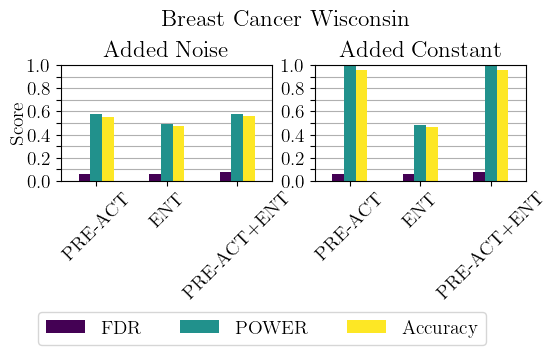

In [30]:
cmap="viridis"


results_test_data = np.concatenate((results_test, results_test_noise), axis=0)
y_true_out = [*np.zeros(len(results_test)), *np.ones(len(results_test_constant))]
#y_true_pred = [*y_test, *[5 for _ in range(len(results_test_constant))]]
y_true_pred = [*y_test, *[1 if int(i) == 0 else 0 for i in results_test_data[110:, 0]]]
y_hatt_pred = results_test_data[:, 0]




tr_breast = testing_framework(X_train_results=results_train)

res = tr_breast.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=False,
                      pre_act=True)

res = tr_breast.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=False)


res = tr_breast.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=True)

tr_breast.test_FDR_and_POWER(y_true_out, 
                            tr_breast.results,
                            y_true_pred,
                            y_hatt_pred)

test_df = pd.concat((tr_breast.FDR_results, tr_breast.POWER_results))
test_df = pd.concat((test_df, tr_breast.ACC_results))



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 1.5)) # , sharey=True





plt.suptitle("Breast Cancer Wisconsin", y=1.25)

test_df.T.plot.bar(title="Added Noise", ax=axes[0], colormap=cmap)
#axes[0].legend(["FDR", "POWER", "Accuracy"])
#axes[0].set_xlabel("Method")
axes[0].set_axisbelow(True)
axes[0].grid(axis='y')
axes[0].get_legend().remove()
#axes[0].tick_params(labelrotation=45)
axes[0].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[0].set_ylim(0, 1)
axes[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])



results_test_data = np.concatenate((results_test, results_test_constant), axis=0)
y_true_out = [*np.zeros(len(results_test)), *np.ones(len(results_test_constant))]
#y_true_pred = [*y_test, *[5 for _ in range(len(results_test_constant))]]
y_true_pred = [*y_test, *[1 if int(i) == 0 else 0 for i in results_test_data[110:, 0]]]
y_hatt_pred = results_test_data[:, 0]



tr_breast = testing_framework(X_train_results=results_train)

res = tr_breast.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=False,
                      pre_act=True)

res = tr_breast.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=False)


res = tr_breast.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=True)




tr_breast.test_FDR_and_POWER(y_true_out, 
                            tr_breast.results,
                            y_true_pred,
                            y_hatt_pred)

test_df = pd.concat((tr_breast.FDR_results, tr_breast.POWER_results))
test_df = pd.concat((test_df, tr_breast.ACC_results))


test_df.T.plot.bar(title="Added Constant", ax=axes[1], colormap=cmap)
#axes[1].legend(["FDR", "POWER", "Accuracy"])
#axes[1].set_xlabel("Method")
axes[1].set_axisbelow(True)
axes[1].grid(axis='y')
axes[1].get_legend().remove()
#axes[1].tick_params(labelrotation=45)
axes[1].set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
axes[1].set_ylim(0, 1)
axes[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])


#for p in axes[1].containers:
#    axes[1].bar_label(p, fmt='%.2f', label_type='edge', rotation=90, fontsize=10)



#fig.text(0.5, -0.2, 'Method', ha='center')
fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

labels=["FDR", "POWER", "Accuracy"]
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.85,-1.05), ncol=len(labels), bbox_transform=fig.transFigure)


plt.show()

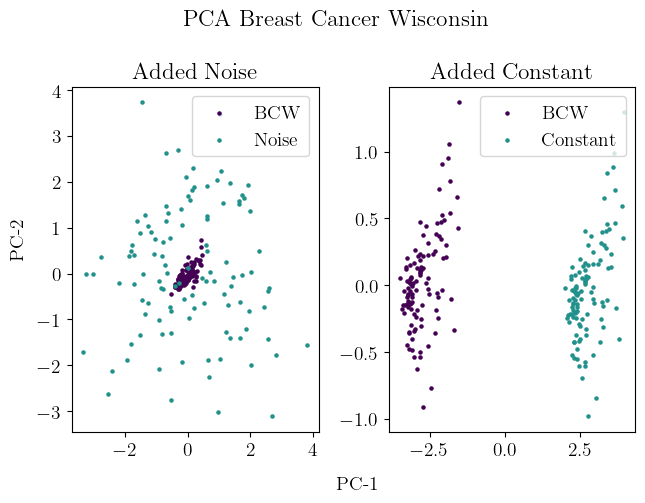

In [31]:
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)


fig, axes = plt.subplots(nrows=1, ncols=2) # , sharey=True


plt.suptitle("PCA Breast Cancer Wisconsin")


pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(X_test_noise_full)

axes[0].scatter(converted_data[:110, 0], converted_data[:110, 1], s = 5, c = "#440154", label="BCW") 
axes[0].scatter(converted_data[110:, 0], converted_data[110:, 1], s = 5, c = "#21918c", label="Noise")
axes[0].set_title("Added Noise")
axes[0].legend(["BCW", "Noise"], frameon=True)

pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(X_test_constant)

axes[1].scatter(converted_data[:110, 0], converted_data[:110, 1], s = 5, c = "#440154", label="BCW") 
axes[1].scatter(converted_data[110:, 0], converted_data[110:, 1], s = 5, c = "#21918c", label="Constant") 
axes[1].set_title("Added Constant")
axes[1].legend(["BCW", "Constant"], frameon=True)


fig.text(-0.01, 0.5, 'PC-2', va='center', rotation='vertical')
fig.text(0.5, -0.01, 'PC-1', va='center')
plt.tight_layout()
plt.show()